In [2]:
# -*- coding: utf-8 -*-

import pandas as pd
import numpy as np
from time import perf_counter
import matplotlib.pyplot as plt
import numpy as np

In [3]:
## Création du jeu de données 

n = 10000000
df = pd.DataFrame (
np.random.randint(0, 2, size=(n, 1)),
columns=['A'])

In [4]:
class PerformanceLogger:
    
    """Cette classe nous permettra d'évaleur graphiquement la performance des éventuels solutions afin de 
    pouvoir les comparer
    """
    
    def __init__(self, *functions, start=0, end=1000, step=5):
        self.functions = functions
        self.start = start
        self.end = end
        self.step = step
        
    def __repr__(self):
        representation = f"Evaluation of the perfomance of the following functions :\n"
        for function in self.functions:
            representation += f"Evaluating performance of : {function.__name__}\n"
        return representation

    def showPerformance(self):
        times = []
        for n in range (self.start, self.end, self.step):
            df = pd.DataFrame(np.random.randint(0, 2, size=(n, 1)), columns=['A'])
            time = []
            for function in self.functions:
                start = perf_counter()
                function(df)
                end = perf_counter()
                time.append(end - start)
            times.append(time)

        X = np.arange(self.start, self.end, self.step)
        for i in range(len(times[0])):
            plt.plot(X, [time[i] for time in times] ,label = f'{self.functions[i].__name__}')
        plt.xlabel("Taille du dataframe")
        plt.ylabel("Temps d'exécution (s)")
        plt.legend()
        plt.show()

In [5]:
def count_state_changes_for_iterrows(df):

    """
    La première fonction qui est développée utilise une méthode naive de parcours 
    de liste, pour trouver les indices des changements d'états et incrémenter un compteur
    dédié à cet effet. Cela reste toujours intéressant de la développer pour pouvoir comparer
    nos futurs autres solutions à la première solution proposée pour déterminer leur pertinence. 
    """

    count = 0
    prev = df.iat[0, 0]
    states_change = [0]
    for _, row in df.iloc[1:].iterrows():
        cur = row['A']
        if prev == cur:
            count+=1
        else:
            count = 0
            prev = cur
        states_change.append(count)
    df['B'] = states_change
    return df

In [6]:
def count_state_changes_for_index(df):

    """
    La deuxième fonction utilisée ne modifie la première que par l'élément sur lequel on itère, en l'occurence 
    df.iloc[1:].iterrows() devient simplement df.iloc[0, 1:]. Cette fonction s'exécute beaucoup plus rapidement. 
    Nous la prendrons donc comme référence pour la suite. 
    
    """
    start = perf_counter()
    
    count = 0
    prev = df.iat[0, 0]
    states_change = [0]
    for cur in df.iloc[1:, 0]:
        if prev == cur:
            count+=1
        else:
            count = 0
            prev = cur
        states_change.append(count)
        
    start1 = perf_counter()
    
    df['B'] = states_change
    
    start2 = perf_counter()
    
    # print(start1 - start)
    # print(start2 - start1)
    
    return df

In [7]:
def count_state_changes_groupby(df):

    """
    La troisième solution consite à implémenter une structure de donner suffisamment pertinente 
    pour pouvoir utiliser la fonction groupby de pandas. 
    L'idée est de construire le tableau des différence entre les états, puis de l'utiliser pour 
    indexer de manière unique les états qui se suivent. De cette manière, on peut utiliser la fonction
    groupby de pandas pour grouper ces éléments ensemble et compter la taille de ces groupes pour construire la 
    colonne B.  
    """
    
    states_change = df['A'] != df['A'].shift(1)

    """
    Pour indexer de manière unique les groupes d'états, on utilise une somme cumulative
    qui nous permet d'avoir l'indice de chaque état.  
    """

    group_indexes = states_change.cumsum()
    groups = df['A'].groupby(group_indexes)


    state_changes_count = groups.count().apply(lambda x: list(range(x))).explode()
    df["B"] = state_changes_count.reset_index(drop=True)

    return df

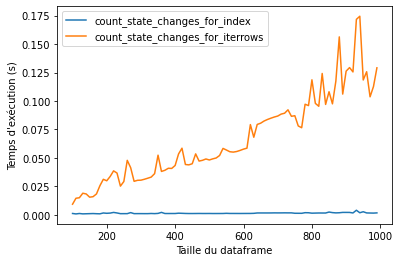

In [8]:
pf = PerformanceLogger(count_state_changes_for_index,
                       count_state_changes_for_iterrows, start = 100, end = 1000, step=10)
pf.showPerformance()

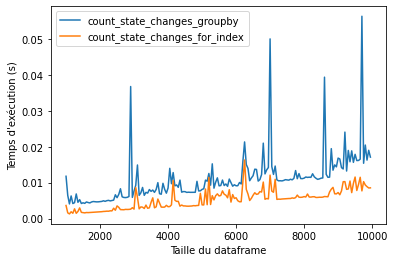

In [9]:
pf = PerformanceLogger(count_state_changes_groupby, 
                       count_state_changes_for_index,
                       start = 1000, end = 10000, step=50)
pf.showPerformance()

In [10]:
start = perf_counter()
print(count_state_changes_for_index(df))
end = perf_counter()
print(end - start)

         A  B
0        1  0
1        1  1
2        0  0
3        0  1
4        0  2
...     .. ..
9999995  1  0
9999996  0  0
9999997  0  1
9999998  0  2
9999999  1  0

[10000000 rows x 2 columns]
9.0085354


In [11]:
start = perf_counter()
print(count_state_changes_groupby(df))
end = perf_counter()
print(end - start)

         A  B
0        1  0
1        1  1
2        0  0
3        0  1
4        0  2
...     .. ..
9999995  1  0
9999996  0  0
9999997  0  1
9999998  0  2
9999999  1  0

[10000000 rows x 2 columns]
16.4056396
